# José Luis Padilla Valenzuela

## Algoritmo de Aprendizaje por refuerzo


* Vamos a resolver un problema con Aprendizaje por refuerzo usando los algoritmos del Q-Learning y SARSA-Learning (implementados en este Notebook).


* El problema que queremos resolver es el de encontrar el camino que nos suponga una mayor recompensa (el más corto) desde un estado inicial $[0,0]$ hasta el estado final $[4,4]$, pudiendo realizar 4 tipos de acciones:


<img src="./imgs/007_RL.png" style="width: 250px;"/>


* Como vemos en esta imagen (el entorno) tenemos dos estados en lo que podemos recibir recompensa bien sea negativa (-100) o positiva (+100).

* Para resolver este problema vamos a realizar lo siguiente:
<span></span><br>
    1. [Definición del entorno](#M1)
<span></span><br>
    2. [Implementación de un algoritmo de toma aleatoria de acciones](#M2)
<span></span><br>
    3. [Ejecución: Entorno - Agente](#M3)
<span></span><br>
    4. [Q-Learner: Implementación y Ejecución](#M4)
<span></span><br>
    5. [SARSA-Learner: Implementación y Ejecución](#M5)
<span></span><br>
    6. [Ejecuciones a realizar por el alumno](#M6)


<hr>


## <a name="M1">1.- Definición del entorno</a>


In [1]:
# importamos las librerias necesarias
import pandas as pd
import numpy as np
from copy import deepcopy

# Formato de los decimales en Pandas y la semilla del Random
pd.options.display.float_format = '{:,.2f}'.format
np.random.seed(5)


class Environment(object):
    def __init__(self, action_penalty = -1.0):
        """
        Clase que representa y controla en entorno
        
        :param step_penalty:     Factor de descuento del Reward por acción tomada
        """
        self.actions = {'Arriba': [-1, 0],
                        'Abajo': [1, 0],
                        'Izquierda': [0, -1],
                        'Derecha': [0, 1]}
        self.rewards = [[0.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, -100.0, 100.0]]
        self.action_penalty = action_penalty
        self.state = [0, 0]
        self.final_state = [3, 3]
        self.total_reward = 0.0
        self.actions_done = []

    def reset(self):
        """
        Método que reinicia las variables del entorno y devuelve es estado inicial
       
        :return:    state
        """
        self.total_reward = 0.0
        self.state = [0, 0]
        self.actions_done = []
        return self.state

    def step(self, action):
        """
        Método que ejecuta una acción determinada del conjunto de acciones {Arriba, Abajo, Izquierda, Derecha}
        para guiar al agente en el entorno.
        
        :param action:    Acción a ejecutar
        :return:          (state, reward, is_final_state)
        """
        self.__apply_action(action)
        self.actions_done.append(self.state[:])
        is_final_state = np.array_equal(self.state, self.final_state)
        reward = self.rewards[self.state[0]][self.state[1]] + self.action_penalty
        self.total_reward += reward
        return self.state, reward, is_final_state

    def __apply_action(self, action):
        """
        Método que calcula el nuevo estado a partir de la acción a ejecutar
        
        :param action:    Acción a ejecutar
        """
        self.state[0] += self.actions[action][0]
        self.state[1] += self.actions[action][1]

        # Si me salgo del tablero por arriba o por abajo, me quedo en la posición que estaba
        if self.state[0] < 0:
            self.state[0] = 0
        elif self.state[0] > len(self.rewards) - 1:
            self.state[0] -= 1

        # Si me salgo del tablero por los lados, me quedo en la posición que estaba
        if self.state[1] < 0:
            self.state[1] = 0
        elif self.state[1] > len(self.rewards[0]) - 1:
            self.state[1] -= 1

    def print_path_episode(self):
        """
        Método que imprime por pantalla el camino seguido por el agente 
        
        :return: 
        """
        path = [['-' for _ in range(len(self.rewards))] for _ in range(len(self.rewards[0]))]
        path[0][0] = '0'
        for index, step in enumerate(self.actions_done):
            path[step[0]][step[1]] = str(index + 1)

        print(pd.DataFrame(data = np.array([np.array(xi) for xi in path]),
                           index = ["x{}".format(str(i)) for i in range(len(path))],
                           columns = ["y{}".format(str(i)) for i in range(len(path[0]))]))


<hr>


## <a name="M2">2.- Implementación de un algoritmo de toma aleatoria de acciones</a>




In [2]:
class Learner(object):

    def __init__(self, environment, learning_rate = 0.1, discount_factor = 0.1, ratio_exploration = 0.05):
        """
        Clase que implementa un algoritmo de aprendiza por refuerzo
        Esta clase implementa un algoritmo de selección aleatoria de acciones
        
        :param environment:         Entorno en el que tomar las acciones
        :param learning_rate:       Factor de aprendizaje
        :param discount_factor:     Factor de descuento (0=Estrategia a corto plazo, 1=Estrategia a largo plazo)
        :param ratio_exploration:   Ratio de exploración
        """
        self.environment = environment
        self.q_table = [[[0.0 for _ in self.environment.actions]
                         for _ in range(len(self.environment.rewards))]
                        for _ in range(len(self.environment.rewards[0]))]
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.ratio_exploration = ratio_exploration

    @property
    def name(self):
        return 'random'

    def get_next_action(self, state):
        """
        Método que selecciona la siguiente acción a tomar:
        
            Aleatoria    -> si el ratio de exploración es inferior al umbral
            Mejor Acción -> si el ratio de exploración es superior al umbral
        :param state:       Estado del agente
        :return:            next_action
        """

        if np.random.uniform() < self.ratio_exploration:
            # Selecciono una opción al azar
            next_action = np.random.choice(list(self.environment.actions))
        else:
            # Selecciono la acción que me de mayor valor. Si hay empate, selecciono una al azar
            idx_action = np.random.choice(np.flatnonzero(
                self.q_table[state[0]][state[1]] == np.array(self.q_table[state[0]][state[1]]).max()
            ))
            next_action = list(self.environment.actions)[idx_action]

        return next_action

    def update(self, ** kwargs):
        """
        Actualiza la Q-Table
        :param kwargs: 
        """
        pass

    def print_q_table(self):
        """
        Método que imprime por pantalla la Q-Table
        """
        print("Actions = {}".format(' - '.join([k for k, v in self.environment.actions.items()])))
        for row in self.q_table:
            for col in row:
                print('[', end = '')
                for val in col:
                    print('{:0.2f}'.format(val), end = ' ')
                print('] ', end = '')
            print()

    def print_best_values_states(self):
        """
        Método que imprime por pantalla el valor de la mejor opción a realizar en cada uno de los estados
        """
        best = [[max(vi) for vi in row] for row in self.q_table]
        print(pd.DataFrame(data = np.array([np.array(xi) for xi in best]),
                           index = ["x{}".format(str(i)) for i in range(len(best))],
                           columns = ["y{}".format(str(i)) for i in range(len(best[0]))]))


<hr>


## <a name="M3">3.- Ejecución: Entorno - Agente</a>




In [3]:
def run_agent(learner = Learner, num_episodes = 10, learning_rate = 0.1, discount_factor = 0.1, ratio_exploration = 0.05,
              verbose = False):
    """
    Método que ejecuta el proceso de aprendizaje del agente en un entorno
    
    :param learner:              Algoritmo de Aprendizaje
    :param num_episodes:         Número de veces que se ejecuta (o aprende) el agente en el entorno
    :param learning_rate:        Factor de Aprendizaje
    :param discount_factor:      Factor de descuento (0=Estrategia a corto plazo, 1=Estrategia a largo plazo)
    :param ratio_exploration:    Ratio de exploración
    :param verbose:              Boolean, si queremos o no imprimir por pantalla información del proceso
    :return:                     (episodes_list, best_episode)
    """

    # Instanciamos el entorno
    environment = Environment()

    # Instanciamos el método de aprendizaje
    learner = learner(environment = environment,
                      learning_rate = learning_rate,
                      discount_factor = discount_factor,
                      ratio_exploration = ratio_exploration)

    # Variables para guardar la información de los episodios
    episodes_list = []
    best_reward = float('-inf')
    best_episode = None

    for n_episode in range(0, num_episodes):
        state = environment.reset()
        reward = None
        is_final_state = None
        num_steps_episode = 0
        while (is_final_state != True):
            old_state = state[:]
            next_action = learner.get_next_action(state=state)
            state, reward, is_final_state = environment.step(next_action)
            next_post_action = learner.get_next_action(state) if learner.name == 'SARSA' else None
            learner.update(environment = environment,
                           old_state = old_state,
                           action_taken = next_action,
                           reward_action_taken = reward,
                           new_state = state,
                           new_action = next_post_action,
                           is_final_state = is_final_state)
            num_steps_episode += 1

        # Guardamos la información del episodio
        episodes_list.append([n_episode + 1, num_steps_episode, environment.total_reward])

        # Guardamos el mejor episodio
        if environment.total_reward >= best_reward:
            best_reward = environment.total_reward
            best_episode = {'num_episode': n_episode + 1,
                            'episode': deepcopy(environment),
                            'learner': deepcopy(learner)}

        if verbose:
            # Imprimimos la información de los episodios
            print('EPISODIO {} - Numero de acciones: {} - Reward: {}'
                  .format(n_episode + 1, num_steps_episode, environment.total_reward))

    return episodes_list, best_episode


def print_process_info(episodes_list, best_episode, print_best_episode_info = True,
                       print_q_table = True, print_best_values_states = True,
                       print_steps = True, print_path = True):
    """
    Método que imprime por pantalla los resultados de la ejecución
    """
    if print_best_episode_info:
        print('\nMEJOR (ÚLTIMO) EPISODIO:\n\EPISODIO {}\n\tNumero de acciones: {}\n\tReward: {}'
              .format(best_episode['num_episode'],
                      len(best_episode['episode'].actions_done),
                      best_episode['episode'].total_reward))

    if print_q_table:
        print('\nQ_TABLE:')
        best_episode['learner'].print_q_table()

    if print_best_values_states:
        print('\nBEST Q_TABLE VALUES:')
        best_episode['learner'].print_best_values_states()

    if print_steps:
        print('\nPasos: \n   {}'.format(best_episode['episode'].actions_done))

    if print_path:
        print('\nPATH:')
        best_episode['episode'].print_path_episode()


### Ejecución:

* En este primer ejemplo de toma de decisiones en el que se usa una política aleatoria, podemos observar como el agente no aprende nada y los movimientos son aleatorios en los 10 episodios que ejecutamos.

In [4]:
episodes_list, best_episode = run_agent(learner = Learner, 
                                        verbose = True)

print_process_info(episodes_list = episodes_list, 
                    best_episode = best_episode)

EPISODIO 1 - Numero de acciones: 91 - Reward: -391.0
EPISODIO 2 - Numero de acciones: 19 - Reward: 81.0
EPISODIO 3 - Numero de acciones: 17 - Reward: -117.0
EPISODIO 4 - Numero de acciones: 60 - Reward: -360.0
EPISODIO 5 - Numero de acciones: 312 - Reward: -2012.0
EPISODIO 6 - Numero de acciones: 148 - Reward: -648.0
EPISODIO 7 - Numero de acciones: 19 - Reward: 81.0
EPISODIO 8 - Numero de acciones: 216 - Reward: -616.0
EPISODIO 9 - Numero de acciones: 52 - Reward: 48.0
EPISODIO 10 - Numero de acciones: 45 - Reward: 55.0

MEJOR (ÚLTIMO) EPISODIO:
\EPISODIO 7
	Numero de acciones: 19
	Reward: 81.0

Q_TABLE:
Actions = Arriba - Abajo - Izquierda - Derecha
[0.00 0.00 0.00 0.00 ] [0.00 0.00 0.00 0.00 ] [0.00 0.00 0.00 0.00 ] [0.00 0.00 0.00 0.00 ] 
[0.00 0.00 0.00 0.00 ] [0.00 0.00 0.00 0.00 ] [0.00 0.00 0.00 0.00 ] [0.00 0.00 0.00 0.00 ] 
[0.00 0.00 0.00 0.00 ] [0.00 0.00 0.00 0.00 ] [0.00 0.00 0.00 0.00 ] [0.00 0.00 0.00 0.00 ] 
[0.00 0.00 0.00 0.00 ] [0.00 0.00 0.00 0.00 ] [0.00 0.00 0.00

<hr>


## <a name="M4">4.- Q-Learner: Implementación y Ejecución</a>


* Recordemos el Pseudocódigo del Algoritmo:


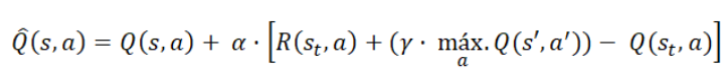


In [5]:
class QLearner(Learner):

    @property
    def name(self):
        return 'QLearner'

    def update(self, environment, old_state, action_taken, reward_action_taken, new_state, is_final_state, ** kwargs):
        """
        Método que implementa el Algoritmo de aprendizaje del Q-Learning
        
        :param environment:          Entorno en el que tomar las acciones
        :param old_state:            Estado actual
        :param action_taken:         Acción a realizar
        :param reward_action_taken:  Recompensa obtenida por la acción tomada
        :param new_state:            Nuevo estado al que se mueve el agente
        :param is_final_state:       Boolean. Devuelvel True si el agente llega al estado final; si no, False
        :param kwargs: 
        """
        # Obtengo el identificador de la acción
        idx_action_taken = list(environment.actions).index(action_taken)

        # Obtengo el valor de la acción tomada
        actual_q_value_options = self.q_table[old_state[0]][old_state[1]]
        actual_q_value = actual_q_value_options[idx_action_taken]

        future_q_value_options = self.q_table[new_state[0]][new_state[1]]
        future_max_q_value = reward_action_taken + self.discount_factor * max(future_q_value_options)
        if is_final_state:
            # Reward máximo si llego a la posición final
            future_max_q_value = reward_action_taken

        self.q_table[old_state[0]][old_state[1]][idx_action_taken] = \
            actual_q_value + self.learning_rate * (future_max_q_value - actual_q_value)


### Ejecución con una estrategia a corto plazo

* En esta ejecución podemos ver como el agente aprende a interactuar con el entorno siguiendo una estrategia a corto plazo (discount_factor=0.1) pero los movimientos los realiza hacia el estado que mayor recompensa parcial le de y no tiene muy encuenta la recompensa final.

In [6]:
episodes_list, best_episode = run_agent(learner = QLearner,
                                        num_episodes = 25,
                                        learning_rate = 0.1,
                                        discount_factor = 0.1,
                                        ratio_exploration = 0.05,
                                        verbose = True)

print_process_info(episodes_list = episodes_list,
                    best_episode = best_episode)

EPISODIO 1 - Numero de acciones: 41 - Reward: -41.0
EPISODIO 2 - Numero de acciones: 52 - Reward: -52.0
EPISODIO 3 - Numero de acciones: 29 - Reward: 71.0
EPISODIO 4 - Numero de acciones: 18 - Reward: 82.0
EPISODIO 5 - Numero de acciones: 35 - Reward: 65.0
EPISODIO 6 - Numero de acciones: 6 - Reward: 94.0
EPISODIO 7 - Numero de acciones: 15 - Reward: 85.0
EPISODIO 8 - Numero de acciones: 13 - Reward: 87.0
EPISODIO 9 - Numero de acciones: 43 - Reward: 57.0
EPISODIO 10 - Numero de acciones: 8 - Reward: 92.0
EPISODIO 11 - Numero de acciones: 21 - Reward: -21.0
EPISODIO 12 - Numero de acciones: 11 - Reward: 89.0
EPISODIO 13 - Numero de acciones: 24 - Reward: 76.0
EPISODIO 14 - Numero de acciones: 36 - Reward: 64.0
EPISODIO 15 - Numero de acciones: 7 - Reward: 93.0
EPISODIO 16 - Numero de acciones: 41 - Reward: 59.0
EPISODIO 17 - Numero de acciones: 17 - Reward: 83.0
EPISODIO 18 - Numero de acciones: 14 - Reward: 86.0
EPISODIO 19 - Numero de acciones: 8 - Reward: 92.0
EPISODIO 20 - Numero d

### Ejecución con una estrategia a largo plazo

* En esta ejecución podemos ver como el agente aprende a interactuar con el entorno siguiendo una estrategia a largo plazo (discount_factor=0.9), realizando movimientos que le den una recompesa final mayor y no asi una recompensa parcial mayor.

In [7]:
episodes_list, best_episode = run_agent(learner = QLearner,
                                        num_episodes = 25,
                                        learning_rate = 0.1,
                                        discount_factor = 0.9,
                                        ratio_exploration = 0.05,
                                        verbose = True)

print_process_info(episodes_list = episodes_list,
                    best_episode = best_episode)

EPISODIO 1 - Numero de acciones: 20 - Reward: -120.0
EPISODIO 2 - Numero de acciones: 41 - Reward: 59.0
EPISODIO 3 - Numero de acciones: 21 - Reward: 79.0
EPISODIO 4 - Numero de acciones: 54 - Reward: 46.0
EPISODIO 5 - Numero de acciones: 23 - Reward: 77.0
EPISODIO 6 - Numero de acciones: 14 - Reward: 86.0
EPISODIO 7 - Numero de acciones: 17 - Reward: 83.0
EPISODIO 8 - Numero de acciones: 8 - Reward: 92.0
EPISODIO 9 - Numero de acciones: 19 - Reward: 81.0
EPISODIO 10 - Numero de acciones: 11 - Reward: 89.0
EPISODIO 11 - Numero de acciones: 16 - Reward: 84.0
EPISODIO 12 - Numero de acciones: 11 - Reward: 89.0
EPISODIO 13 - Numero de acciones: 6 - Reward: 94.0
EPISODIO 14 - Numero de acciones: 8 - Reward: 92.0
EPISODIO 15 - Numero de acciones: 13 - Reward: 87.0
EPISODIO 16 - Numero de acciones: 7 - Reward: 93.0
EPISODIO 17 - Numero de acciones: 7 - Reward: 93.0
EPISODIO 18 - Numero de acciones: 7 - Reward: 93.0
EPISODIO 19 - Numero de acciones: 7 - Reward: 93.0
EPISODIO 20 - Numero de ac

<hr>


## <a name="M5">5.- SARSA-Learner: Implementación y Ejecución</a>


* Recordemos el Pseudocódigo del Algoritmo:


<img src="./imgs/014_sarsa.png" style="width: 500px;"/>

In [8]:
class SARSALearner(Learner):

    @property
    def name(self):
        return 'SARSA'

    def update(self, environment, old_state, action_taken, reward_action_taken, new_state, new_action, is_final_state):
        """
        Método que implementa el algoritmo de aprendizaje SARSA
        
        :param environment:             Entorno en el que tomar las acciones
        :param old_state:               Estado actual
        :param action_taken:            Acción a realizar
        :param reward_action_taken:     Recompensa obtenida por la acción tomada
        :param new_state:               Nuevo estado al que se mueve el agente 
        :param new_action:              Acción a tomar en el nuevo estado
        :param is_final_state:          Boolean. Devuelvel True si el agente llega al estado final; si no, False 
        """
        # Obtengo el identificador de la acción
        idx_action_taken = list(environment.actions).index(action_taken)

        # Obtengo el valor de la acción tomada
        actual_q_value_options = self.q_table[old_state[0]][old_state[1]]
        actual_q_value = actual_q_value_options[idx_action_taken]

        future_q_value_options = self.q_table[new_state[0]][new_state[1]]

        idx_new_action_taken = list(environment.actions).index(new_action)
        future_new_action_q_value = \
            reward_action_taken + self.discount_factor * future_q_value_options[idx_new_action_taken]
        if is_final_state:
            # Reward máximo si llego a la posición final
            future_new_action_q_value = reward_action_taken  # reward máximo

        self.q_table[old_state[0]][old_state[1]][idx_action_taken] = \
            actual_q_value + self.learning_rate * (future_new_action_q_value - actual_q_value)


### Ejecución con una estrategia a corto plazo

* En esta ejecución podemos ver como el agente aprende a interactuar con el entorno siguiendo una estrategia a corto plazo (discount_factor=0.1) pero los movimientos los realiza hacia el estado que mayor recompensa parcial le de y no tiene muy encuenta la recompensa final.

In [9]:
episodes_list, best_episode = run_agent(learner = SARSALearner,
                                        num_episodes = 25,
                                        learning_rate = 0.1,
                                        discount_factor = 0.1,
                                        ratio_exploration = 0.05,
                                        verbose = True)

print_process_info(episodes_list = episodes_list,
                    best_episode = best_episode)

EPISODIO 1 - Numero de acciones: 115 - Reward: -315.0
EPISODIO 2 - Numero de acciones: 28 - Reward: 72.0
EPISODIO 3 - Numero de acciones: 7 - Reward: 93.0
EPISODIO 4 - Numero de acciones: 16 - Reward: 84.0
EPISODIO 5 - Numero de acciones: 15 - Reward: 85.0
EPISODIO 6 - Numero de acciones: 40 - Reward: 60.0
EPISODIO 7 - Numero de acciones: 8 - Reward: 92.0
EPISODIO 8 - Numero de acciones: 19 - Reward: 81.0
EPISODIO 9 - Numero de acciones: 16 - Reward: 84.0
EPISODIO 10 - Numero de acciones: 50 - Reward: 50.0
EPISODIO 11 - Numero de acciones: 15 - Reward: 85.0
EPISODIO 12 - Numero de acciones: 28 - Reward: 72.0
EPISODIO 13 - Numero de acciones: 17 - Reward: 83.0
EPISODIO 14 - Numero de acciones: 14 - Reward: 86.0
EPISODIO 15 - Numero de acciones: 15 - Reward: 85.0
EPISODIO 16 - Numero de acciones: 50 - Reward: 50.0
EPISODIO 17 - Numero de acciones: 15 - Reward: 85.0
EPISODIO 18 - Numero de acciones: 10 - Reward: 90.0
EPISODIO 19 - Numero de acciones: 30 - Reward: 70.0
EPISODIO 20 - Numero

### Ejecución con una estrategia a largo plazo

* En esta ejecución podemos ver como el agente aprende a interactuar con el entorno siguiendo una estrategia a largo plazo (discount_factor=0.9), realizando movimientos que le den una recompesa final mayor y no asi una recompensa parcial mayor.

In [10]:
episodes_list, best_episode = run_agent(learner = SARSALearner,
                                        num_episodes = 25,
                                        learning_rate = 0.1,
                                        discount_factor = 0.9,
                                        ratio_exploration = 0.05,
                                        verbose = True)

print_process_info(episodes_list = episodes_list,
                    best_episode = best_episode)

EPISODIO 1 - Numero de acciones: 23 - Reward: -223.0
EPISODIO 2 - Numero de acciones: 34 - Reward: 66.0
EPISODIO 3 - Numero de acciones: 50 - Reward: 50.0
EPISODIO 4 - Numero de acciones: 35 - Reward: 65.0
EPISODIO 5 - Numero de acciones: 14 - Reward: 86.0
EPISODIO 6 - Numero de acciones: 15 - Reward: 85.0
EPISODIO 7 - Numero de acciones: 31 - Reward: 69.0
EPISODIO 8 - Numero de acciones: 7 - Reward: 93.0
EPISODIO 9 - Numero de acciones: 7 - Reward: 93.0
EPISODIO 10 - Numero de acciones: 6 - Reward: 94.0
EPISODIO 11 - Numero de acciones: 10 - Reward: 90.0
EPISODIO 12 - Numero de acciones: 17 - Reward: 83.0
EPISODIO 13 - Numero de acciones: 7 - Reward: 93.0
EPISODIO 14 - Numero de acciones: 6 - Reward: 94.0
EPISODIO 15 - Numero de acciones: 9 - Reward: 91.0
EPISODIO 16 - Numero de acciones: 16 - Reward: 84.0
EPISODIO 17 - Numero de acciones: 7 - Reward: 93.0
EPISODIO 18 - Numero de acciones: 6 - Reward: 94.0
EPISODIO 19 - Numero de acciones: 10 - Reward: 90.0
EPISODIO 20 - Numero de acc

<hr>


## <a name="M6">6.- Ejecuciones a realizar por el alumno:</a>


* Se piden realizar las siguientes 2 ejecuciones:

    1. Ejecutar con el algoritmo de Q-Learning o SARSA (uno de los dos) 30 episodios con un ratio de exploración del 95% y un factor de descuento de 0.3.
    
    2. Ejecutar con el algoritmo de Q-Learning o SARSA (uno de los dos) 150 episodios con un ratio de exploración del 5%, un factor de descuento de 0.9 y un ratio de aprendizaje del 1% (learning_rate=0.01).
    
    
* Para ambas ejecuciones se pide justifucar los resultados obtenidos en el notebook.

    ***1: JUSTIFICACIÓN:*** A completar por el alumno
    
    ***2: JUSTIFICACIÓN:*** A completar por el alumno


<hr>


#### 1. Ejecutar con el algoritmo de Q-Learning o SARSA (uno de los dos) 30 episodios con un ratio de exploración del 95% y un factor de descuento de 0.3.

In [11]:
# TODO
episodes_list, best_episode = run_agent(learner = SARSALearner,
                                        num_episodes = 30,
                                        learning_rate = 0.1,
                                        discount_factor = 0.3,
                                        ratio_exploration = 0.95,
                                        verbose = True)

print_process_info(episodes_list = episodes_list,
                    best_episode = best_episode)

EPISODIO 1 - Numero de acciones: 145 - Reward: -145.0
EPISODIO 2 - Numero de acciones: 24 - Reward: -24.0
EPISODIO 3 - Numero de acciones: 6 - Reward: 94.0
EPISODIO 4 - Numero de acciones: 19 - Reward: -119.0
EPISODIO 5 - Numero de acciones: 63 - Reward: -663.0
EPISODIO 6 - Numero de acciones: 38 - Reward: -238.0
EPISODIO 7 - Numero de acciones: 106 - Reward: -206.0
EPISODIO 8 - Numero de acciones: 76 - Reward: -76.0
EPISODIO 9 - Numero de acciones: 20 - Reward: 80.0
EPISODIO 10 - Numero de acciones: 17 - Reward: -17.0
EPISODIO 11 - Numero de acciones: 48 - Reward: -48.0
EPISODIO 12 - Numero de acciones: 38 - Reward: -38.0
EPISODIO 13 - Numero de acciones: 51 - Reward: -251.0
EPISODIO 14 - Numero de acciones: 44 - Reward: -44.0
EPISODIO 15 - Numero de acciones: 65 - Reward: -65.0
EPISODIO 16 - Numero de acciones: 96 - Reward: 4.0
EPISODIO 17 - Numero de acciones: 44 - Reward: 56.0
EPISODIO 18 - Numero de acciones: 64 - Reward: 36.0
EPISODIO 19 - Numero de acciones: 90 - Reward: -190.0


<hr>

#### 2. Ejecutar con el algoritmo de Q-Learning o SARSA (uno de los dos) 150 episodios con un ratio de exploración del 5%, un factor de descuento de 0.9 y un ratio de aprendizaje del 1% (learning_rate=0.01).

In [12]:
# TODO
episodes_list, best_episode = run_agent(learner = SARSALearner,
                                        num_episodes = 150,
                                        learning_rate = 0.1,
                                        discount_factor = 0.9,
                                        ratio_exploration = 0.05,
                                        verbose = True)

print_process_info(episodes_list = episodes_list,
                    best_episode = best_episode)

EPISODIO 1 - Numero de acciones: 37 - Reward: 63.0
EPISODIO 2 - Numero de acciones: 20 - Reward: 80.0
EPISODIO 3 - Numero de acciones: 12 - Reward: -112.0
EPISODIO 4 - Numero de acciones: 16 - Reward: -116.0
EPISODIO 5 - Numero de acciones: 29 - Reward: 71.0
EPISODIO 6 - Numero de acciones: 14 - Reward: 86.0
EPISODIO 7 - Numero de acciones: 11 - Reward: 89.0
EPISODIO 8 - Numero de acciones: 14 - Reward: 86.0
EPISODIO 9 - Numero de acciones: 10 - Reward: 90.0
EPISODIO 10 - Numero de acciones: 16 - Reward: 84.0
EPISODIO 11 - Numero de acciones: 8 - Reward: 92.0
EPISODIO 12 - Numero de acciones: 18 - Reward: 82.0
EPISODIO 13 - Numero de acciones: 7 - Reward: 93.0
EPISODIO 14 - Numero de acciones: 20 - Reward: 80.0
EPISODIO 15 - Numero de acciones: 6 - Reward: 94.0
EPISODIO 16 - Numero de acciones: 10 - Reward: 90.0
EPISODIO 17 - Numero de acciones: 6 - Reward: 94.0
EPISODIO 18 - Numero de acciones: 6 - Reward: 94.0
EPISODIO 19 - Numero de acciones: 9 - Reward: 91.0
EPISODIO 20 - Numero de